# Utility Functions

In [1]:
# type annotations
from typing import List, Set, Tuple
from datetime import datetime, date
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
from praw import Reddit
from psaw import PushshiftAPI
from collections import Counter
import spacy
from spacy.lang.en import English
from spacy.tokens import DocBin
nlp = spacy.load("en_core_web_sm")

In [2]:
def word_per_year(df: pd.DataFrame, words: List[str], time_str) -> pd.DataFrame:
    """
    Find the number of occurrences of the word per year in the df.
    Also returns a column with word counts normalized by active user counts.
    
    Note: assumes columns names "text" and "year" in the df.
    """
    times: List[str] = list(df[time_str].unique())
    check_in = lambda text: 1 if len(set(words) & set(str(text).split())) > 0 else 0
    countw = lambda time: df.loc[df[time_str] == time, "lower_text"].apply(check_in).sum()
    word_counts: List[int] = [countw(time) for time in times]
    return pd.DataFrame({time_str: times, "word_counts": word_counts})


def append_wc(df: pd.DataFrame, words: List[List[str]], time_str: str) -> pd.DataFrame:
    """Generates a dataframe with multiple word counts for visualization."""
    wc_df = ft.reduce(lambda acc, w: acc.append(word_per_year(df, w, time_str)), words, pd.DataFrame())
    nyear = df[time_str].unique().shape[0]
    word_arr = ft.reduce(lambda acc, w: acc + [w[0]] * nyear, words, [])
    wc_df["words"] = word_arr
    return wc_df

def user_ents(u: str):
    """Get all entities associated with a given user."""
    grouped_ents = ents_df.loc[ents_df["username"] == u, :]["ents"].tolist()
    return ft.reduce(lambda x, y: x + y, grouped_ents, [])


def ents_by_type(ents, etype):
    """Get the text for entities of the given type from the given ents."""
    etypes = [e.text.lower().strip(".") for e in ents if e.label_ == etype]
    return etypes


def row_with_kw(df: pd.DataFrame, kw: str):
    """Returns row indexes of dataframe with ents with the given keyword."""
    return [i for i, ents in enumerate(ents_df["ents"].tolist()) 
            if kw in [str(e).lower() for e in ents]]

def disk_to_spacy(fp: str) -> List[English]:
    """Read spacy documents from disk."""
    docbin = DocBin().from_bytes(open(fp, "rb").read())
    disk_docs = docbin.get_docs(nlp.vocab)
    disk_docsl = list(disk_docs)
    return disk_docsl

def df_by_ent(df, e_name):
    """subset an entity df by the given ent."""
    sub_df = df.copy()
    sub_df[e_name] = sub_df["ents"].apply(lambda ents: [e for e in ents if e.label_ == e_name])
    sub_df[e_name] = sub_df[e_name].apply(lambda ents: ents if len(ents) > 0 else None)
    return sub_df.dropna()

def df_by_user(df, user):
    return df.loc[df["username"] == user, :]

def top_ents(df, e_name):
    """Get most frequent entities"""
    names = [e.text.lower() for e in list(it.chain.from_iterable(df[e_name].tolist()))]
    return Counter(names)

def search_ent(df, word, e_name):
    return


# Read in data

In [3]:
import pymongo
import os
from dotenv import load_dotenv

# define project location
PROJ_DIR = "."

# load local environment variables
ENV_PATH = os.path.join(PROJ_DIR, ".env")
load_dotenv(dotenv_path=ENV_PATH)

# define mongo connection
MONGO = pymongo.MongoClient(os.getenv("HOST"),
                            int(str(os.getenv("PORT"))),
                            username=os.getenv("MUSERNAME"),
                            password=os.getenv("MPASSWORD"),
                            authSource=os.getenv("DB_NAME"))
DB = MONGO[os.getenv("DB_NAME")]
COLL = DB[os.getenv("COLL_NAME")]
TEST_COLL = DB[os.getenv("TEST_COLL_NAME")]

In [4]:
# general processing
import pymongo
from tqdm import tqdm
from collections import Counter

In [5]:
# read in full mongo collection
res = COLL.find({})
df = pd.DataFrame(res)

# Word Usage

In [6]:
vis_df = df.copy()
vis_df["year"] = vis_df["time"].apply(lambda x: x.year)
vis_df["lower_text"] = vis_df["text"].apply(lambda x: str(x).lower())

In [10]:
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

## Location Mentions

In [54]:
# get raw and normalized word counts in df
# NOTE: words is a 2d list with:
# dim 1: a category to count and plot
# dim 2: aliases to include in that category.  can only be a single word for now
loc_words = [["boston", "beantown", "bos"], ["lawrence"], ["lowell"], ["manchester"], ["worcester"]]
loc_df = append_wc(vis_df, loc_words, "year")

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

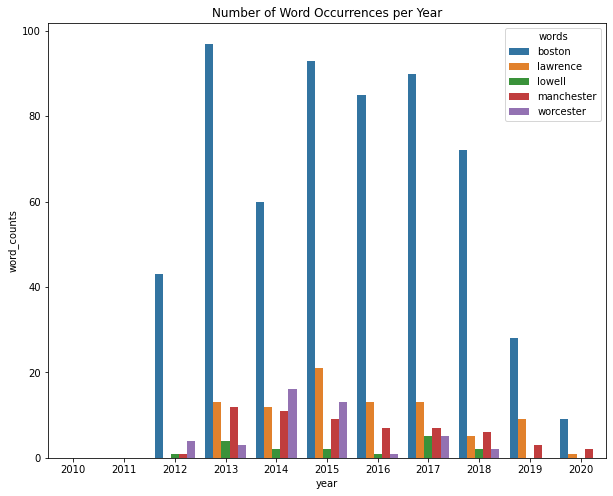

In [55]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="year", y="word_counts", hue="words", data=loc_df)
ax.set_title(f"Number of Word Occurrences per Year")

## Drug Mentions

In [33]:
drug_words = [["fentanyl", "fent", "fenty"], ["heroin"]]
drug_df = append_wc(vis_df, drug_words)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

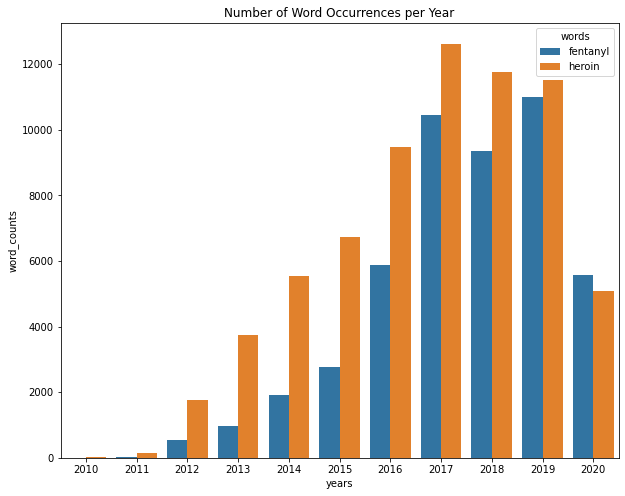

In [34]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="year", y="word_counts", hue="words", data=drug_df)
ax.set_title(f"Number of Word Occurrences per Year")

## Withdrawal Mentions

In [14]:
vis_df_2020 = vis_df.loc[vis_df["year"] == 2020,:].append(vis_df.loc[vis_df["year"] == 2019,:])
vis_df_2020["month"] = vis_df["time"].apply(lambda x: str(x.month) + "." + str(x.year))

In [15]:
# get raw and normalized word counts in df
# NOTE: words is a 2d list with:
# dim 1: a category to count and plot
# dim 2: aliases to include in that category.  can only be a single word for now
with_words = [["withdrawal", "cold turkey", "withdrawing", "wd", "wds"], ["covid-19", "corona", "virus", "quarantine"]]
with_df = append_wc(vis_df_2020, with_words, "month")

In [32]:
with_df["date"] = with_df["month"].apply(lambda x: datetime.strptime(x, "%m.%Y"))

In [ ]:
with_df = with_df.sort_values("")
with_df["datetime"] = with_df

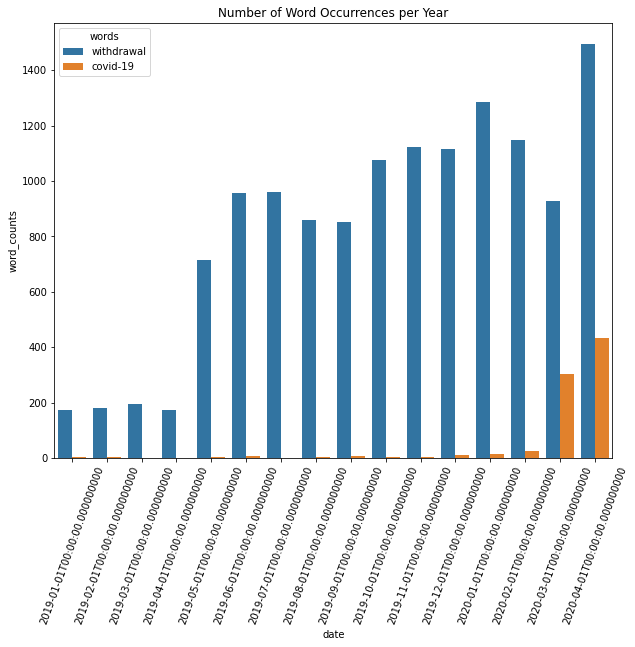

In [36]:
# plot y='word_counts' for raw "counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="date", y="word_counts", hue="words", data=with_df)
ax.set_title(f"Number of Word Occurrences per Year")
plt.xticks(rotation=70)
plt.show()